In [4]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
adult = adult = pd.read_csv('../../datasets/adult_with_pii.csv')

# Composition properties of DP
Note that, the privacy guarantee from DP applies to a single query. That means, if a mechanism satisfies $\epsilon$-DP, it bounds the query result from two neighboring datasets by $\epsilon$ when sending the query only once. This privacy guarantee will not hold for subsequent queries. But in real world, we rarely query a dataet only once. We send many different queries, and even the same query multiple times. Additionally, for some queries, the whole dataset is not required, i.e., the query result can be computed using a part of the dataset. All these changes the privacy guarantee of DP.


## Sequential composition
Sequential composition bounds the total privacy cost of releasing multiple results of differentially private mechanisms on the same input data. Imagine that we first query the dataset about the average age of people working as tech support ( query function $F_1$), and then we query the average number of working hours for them (query function  $F_2$). If  $F_1$ and  $F_2$ both goes through a randomization mechanism to achieve differential privacy, mechanisms $M_1$ and $M_2$, resepectively, with privacy budgets $\epsilon_1$ and $\epsilon_2$, then the total privacy cost for both queries combined will be $\epsilon_1$ + $\epsilon_2$. Thus, as the number of queries goes up, the privacy budget or cost increases, i.e., the privacy protection decreases.

---
**Theorem: Sequential compossition**

If mechanism $M_1$ satisfies $\epsilon_1$-differential privacy and mechahism $M_2$ satisfies $\epsilon_2$-differential privacy then the mechanism $M=M_1 + M_2$ will satisfy $\epsilon_1$ + $\epsilon_2$-differential privacy.

---
See {cite}`dp-theory-practice-book` for the proof.

Sequential composition is a vital property of differential privacy because it allows algorithms to consult
the data multiple times or conduct separate analysis on the data and then compute the total privacy cost for all these analyses.

The bound on privacy cost given by sequential composition is an upper bound - the actual privacy cost of two particular
differentially private releases may be smaller than this, but never larger. Let's see how the privacy budgets "add up"  when we combine two differentially private results together through the examples below (Taken from {cite}`programmingDP2021`. Note that, this sequential composition properties work for any DP mechanism (not just Laplace mechanism).

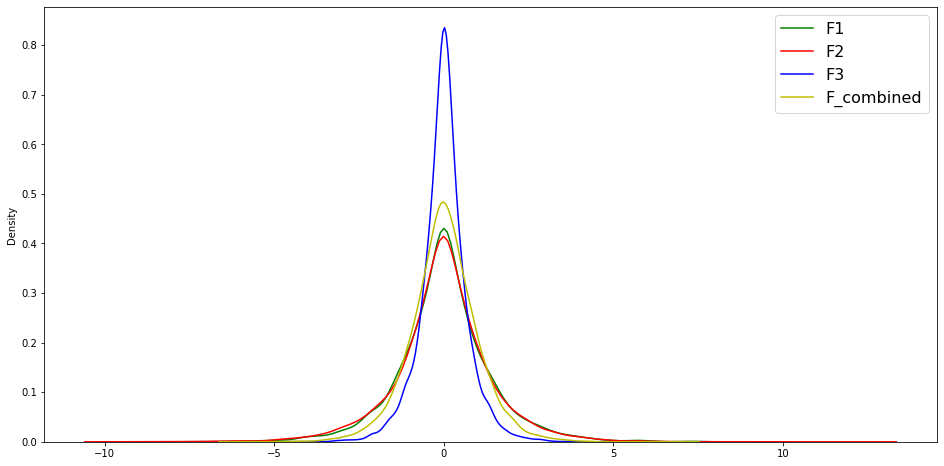

In [53]:


epsilon1 = 1
epsilon2 = 1
epsilon_total = 2
# satisfies 1-differential privacy
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)
# satisfies 1-differential privacy
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)
# satisfies 2-differential privacy
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)
# satisfies 2-differential privacy, by sequential composition
def F_combined():
    return (F1() + F2()) / 2

f1_vals = [F1() for i in range(10000)]
f2_vals = [F2() for i in range(10000)]
f3_vals = [F3() for i in range(10000)]
fc_vals = [F_combined() for i in range(10000)]

fig, axs = plt.subplots(ncols=1, figsize=(16,8))
sns.kdeplot(f1_vals, ax=axs, color='g', label="F1")
sns.kdeplot(f2_vals, ax=axs, color='r',  label="F2")
sns.kdeplot(f3_vals, ax=axs, color='b',  label="F3")
sns.kdeplot(fc_vals, ax=axs, color='y',  label="F_combined")
plt.legend(fontsize=16)
plt.show()


In the aboge graph, for F1 and F2, we see that the distributions of their outputs look pretty similar. But F3 is narrower than the two, i.e. less variance (and hence less privacy). F3 is also narrower than F_combined, proving the point that actual privacy loss may be lower than the theoretical upper bound.

## Parallel composition
Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially
private mechanism on each chunk separately. Since the chunks are disjoint, each individual’s data appears in exactly one
chunk - so even if there are 𝑘 chunks in total (and therefore 𝑘 runs of the mechanism), the mechanism runs exactly once
on the data of each individual. Formally,

---
If mechanism $M$ satisfies $\epsilon$-differential privacy and the dataste $D$ is split into $k$ disjoint chunks where $D$ can be recovered by mergina all chunks, then applying $M$ to all of these chunks and releasing the results will still satisfy $\epsilon$-differential privacy (instead of $k\epsilon$-differential privacy like the sequential composition case). More generally, if there are $k$ mechanisms $M_1, M_2, M_3, \dots, M_k$ with privacy budgets $\epsilon_1, \epsilon_2, \epsilon_3, \dots, \epsilon_k$, then applying these mechanisms on the disjoint chunks will have $max_{i\in[1,2,3,\dots,k]}\epsilon_i$-differential privacy.

---
(See {cite}`dp-theory-practice-book` for the proof.)

A specific scenario is running the same algorithm $M$ over $k$ disjoint chunks of a single dataset $D$. If $M$ satisfies $\epsilon$-DP, then all $k$ queries also jointly satisfy $\epsilon$-DP. This is a much better privacy guarantee than sequential composition (where we would have $k\epsilon$-DP guarantee. 

> The formal definition matches up with our intuition - if each participant in the dataset contributes one row to $D$, then this row will appear in exactly one of the chunks $d_1, d_2, \dots, d_k$. That means $M$ will only “see” this participant’s data one time, meaning a privacy cost of $\epsilon$ is appropriate for that individual. Since this property holds for all individuals, the privacy cost
is $\epsilon$ for everyone.


### Histogram functions
In our context, a histogram is an analysis of a dataset which splits the dataset into “bins” based on the value of one of the
data attributes, and counts the number of rows in each bin. For example, a histogram might count the number of people
in the dataset who achieved a particular educational level

In [18]:
adult['Education'].value_counts().to_frame().head(5)

,Education
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1383


Histograms are particularly interesting for differential privacy because they automatically satisfy parallel composition. Each “bin” in a histogram is defined by a possible value for a data attribute (for example, 'Education' ==
'HS-grad'). It’s impossible for a single row to have two values for an attribute simultaneously, so defining the bins this way guarantees that they will be disjoint. Thus we have satisfied the requirements for parallel composition, and we can use a differentially private mechanism to release all of the bin counts with a total privacy cost of just 𝜖.

In [6]:
epsilon = 1
# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,Education
HS-grad,10501.087944
Some-college,7289.422784
Bachelors,5355.161931
Masters,1723.213431
Assoc-voc,1382.076475


### Contingency table
A contingency table or cross tabulation (often shortened to crosstab) is like a multi-dimensional histogram. It counts the frequency of rows in the dataset with particular values for more than one attribute at a time. Contingency tables are frequently used to show the relationship between two variables when analyzing data. For example, we might want to see counts based on both education level and gender:

In [19]:
pd.crosstab(adult['Education'], adult['Sex']).head(5)

Sex,Female,Male
Education,,
10th,295,638
11th,432,743
12th,144,289
1st-4th,46,122
5th-6th,84,249


It’s safe to use parallel composition here, too.

In [25]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.applymap(f).head(5)

Sex,Female,Male
Education,,
10th,296.333432,637.341978
11th,429.683036,743.559557
12th,144.067246,289.592008
1st-4th,46.012346,122.168553
5th-6th,84.559278,248.719621


It’s also possible to generate contingency tables of more than 2 variables. Consider what happens each time we add a
variable, though: each of the counts tends to get smaller. Intuitively, as we split the dataset into more chunks, each chunk has fewer rows in it, so all of the counts get smaller. These shrinking counts can have a significant affect on the accuracy of the differentially private results we calculate from them. If we think of things in terms of signal and noise, a large count represents a strong signal - it’s unlikely to be
disrupted too much by relatively weak noise (like the noise we add above), and therefore the results are likely to be useful even after the noise is added. However, a small count represents a weak signal - potentially as weak as the noise itself and after we add the noise, we won’t be able to infer anything useful from the results.
So while it may seem that parallel composition gives us something “for free” (more results for the same privacy cost), that’s not really the case. Parallel composition simply moves the tradeoff between accuracy and privacy along a different axis - as we split the dataset into more chunks and release more results, each result contains a weaker signal, and so it’s less accurate.

:::{note}
This text is **standard** _Markdown_
:::

## Post-processing guarantee

The third property of differential privacy we will discuss here is called post-processing. The idea is simple: it’s impossible
to reverse the privacy protection provided by differential privacy by post-processing the data in some way.

---

If $M(D)$ satisfies $\epsilon$-differential privacy then for any (deterministic or randomized) function $\bar{M}$, $\bar{M}M(D)$ satisfies $\epsilon$-differential privacy.

---

The above theorem  guarantees that no additional information about the database will be learned
by adversaries through further computations or process on a DP output. Notice that there
is no assumption on the computational power of the adversary in Theorem 1.
DP is phrased in terms of a single individual, but in practice, we may want privacy for groups.
For example, there can be families whose data is correlated or identical or we may consider
multiple entries in the database of a same individual such as multiple hospital records of a
same patient. Following theorem provides privacy of a group of data.

The post-processing property means that it’s always safe to perform arbitrary computations on the output of a differentially private mechanism - there’s no danger of reversing the privacy protection the mechanism has provided. In particular, it’s fine to perform post-processing that might reduce the noise or improve the signal in the mechanism’s output (e.g. replacing negative results with zeros, for queries that shouldn’t return negative results). In fact, many sophisticated differentially private algorithms make use of post-processing to reduce noise and improve the accuracy of their results. The other implication of the post-processing property is that differential privacy provides resistance against privacy attacks based on auxiliary information. For example, the function 𝑔 might contain auxiliary information about elements of the dataset, and attempt to perform a linkage attack using this information. The post-processing property says that such an attack is limited in its effectiveness by the privacy parameter $\epsilon$, regardless of the auxiliary information contained in $\bar M$.

`````{note} 
:class: tip
-  Sequential composition bounds the total privacy cost of releasing multiple results of differentially private mechanisms
on the same input data.
- Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially
private mechanism on each chunk separately.
- The post-processing property means that it’s always safe to perform arbitrary computations on the output of a differentially private mechanism.
`````